## Bigram Language Model

The Bigram language model functions under a Markov assumption. The basic premise is that every letter has a probability distribution for what letters follow it, as well as whether it's at the beginning or ending of the name. It's a very simple Markov chain that chooses the next letter based on the letter immediately before it. We can randomly intialize a starting letter and build out the name from there. 

In [1]:
import torch 
import matplotlib.pyplot as plt

In [2]:
data = open("names.txt", 'r').read().splitlines()

In [3]:
data[:4]

['emma', 'olivia', 'ava', 'isabella']

In [4]:
for name in data[:4]:
    for i in range(len(name) - 1):
        print(name[i], name[i + 1])

e m
m m
m a
o l
l i
i v
v i
i a
a v
v a
i s
s a
a b
b e
e l
l l
l a


Creating a lookup table for characters.

In [5]:
chars = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
stringtoint = {s:i for i,s in enumerate(chars)}
stringtoint["<S>"] = 26
stringtoint["<E>"] = 27
inttostring = {i: s for i,s in enumerate(chars)}
inttostring[26] = "<S>"
inttostring[27] = "<E>"
inttostring

{0: 'a',
 1: 'b',
 2: 'c',
 3: 'd',
 4: 'e',
 5: 'f',
 6: 'g',
 7: 'h',
 8: 'i',
 9: 'j',
 10: 'k',
 11: 'l',
 12: 'm',
 13: 'n',
 14: 'o',
 15: 'p',
 16: 'q',
 17: 'r',
 18: 's',
 19: 't',
 20: 'u',
 21: 'v',
 22: 'w',
 23: 'x',
 24: 'y',
 25: 'z',
 26: '<S>',
 27: '<E>'}

Creating a 2-d tensor/array which contains how often a letter is followed by another. For example, to see if "a" is followed by "b" we would look at counts[1, 2].

In [6]:
counts = torch.zeros((28,28), dtype=torch.int32)
for name in data:
    name_letters = ["<S>"] + list(name) + ["<E>"]
    for letter1, letter2 in zip(name_letters, name_letters[1:]):
        i1 = stringtoint[letter1]
        i2 = stringtoint[letter2]
        counts[i1, i2] +=1

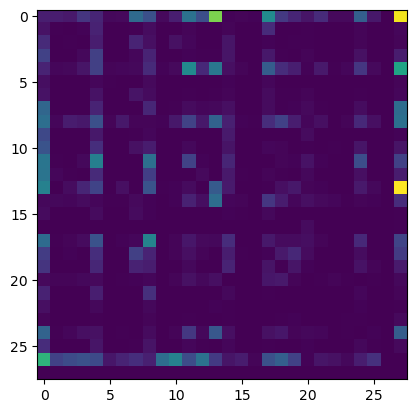

In [7]:
plt.imshow(counts)

In [8]:
counts[0, :]

tensor([ 556,  541,  470, 1042,  692,  134,  168, 2332, 1650,  175,  568, 2528,
        1634, 5438,   63,   82,   60, 3264, 1118,  687,  381,  834,  161,  182,
        2050,  435,    0, 6640], dtype=torch.int32)

Creating probability mapping to sample bigrams from.

In [9]:
probability_map = counts[0].float()
probability_map /= probability_map.sum()
probability_map

tensor([0.0164, 0.0160, 0.0139, 0.0308, 0.0204, 0.0040, 0.0050, 0.0688, 0.0487,
        0.0052, 0.0168, 0.0746, 0.0482, 0.1605, 0.0019, 0.0024, 0.0018, 0.0963,
        0.0330, 0.0203, 0.0112, 0.0246, 0.0048, 0.0054, 0.0605, 0.0128, 0.0000,
        0.1960])

Example of sampling. We feed in the distribution created by the probability map and use torch.multinomial to sample from this given distribtuon. 

In [10]:
ind = torch.multinomial(probability_map, num_samples=1, replacement=True).item()
inttostring[ind]

'm'

For some efficiency and practice, notice that we are taking row-wise sums and dividing them constantly on each iteration. Note that keepdim=True. This allows for normalization across the rows. If we left it out, it would normalize the columns, because of broadcasting semantics.

In [11]:
P = counts.float()
P /= P.sum(1, keepdim=True)

In [12]:
P[0].sum()

tensor(1.)

Establishing loop to create probability distribution for each letter. Also samples some names.

In [13]:
for i in range(10): 
    idx = 26
    out = []
    while True:
    
        p = P[idx]
        
        #next index is randomly sampled from probability distribution from preceding letter
        idx = torch.multinomial(p, num_samples=1, replacement=True).item()
        out.append(inttostring[idx])
        if idx == 27:
            break
    print(''.join(out))

le<E>
al<E>
gar<E>
khth<E>
maeie<E>
mamaizi<E>
shayszirla<E>
tamon<E>
erkan<E>
yndoosk<E>


We will now incorporate the idea of loss into our model. We will do this by using log likelihood (ie we take the product of all probabilities output from our model and then compare it with that of our training set. if it's close to 0, thats good if its more negative then that's bad). To follow the semantics of loss (where less is better), we will minimize the negative log likelihood. For the sake of this bigram model we can just evaluate the quality of the model. 

In [14]:
ll = 0.0
n = 0

for name in data:
    name_letters = ["<S>"] + list(name) + ["<E>"]
    for letter1, letter2 in zip(name_letters, name_letters[1:]):
        i1 = stringtoint[letter1]
        i2 = stringtoint[letter2]
        prob = P[i1, i2]
        log_prob = torch.log(prob)
        ll += log_prob
        n +=1

nll = -1 * ll
average_neg_log_likelihood = nll/n
print(average_neg_log_likelihood)

tensor(2.4541)


## Part 2: Basic Neural Network

We will be using a basic neural network and gradient based optimization rather than markov assumptions to come to a similar name generation state. 

In [15]:
#creating a training set with inputs and outputs. Keep in mind that the input to the neural network will be a single character and the output will be the probability distribution that the subsequent character will be chosen from.

x, y = [], []
for name in data:
    name_letters = ["<S>"] + list(name) + ["<E>"]
    for letter1, letter2 in zip(name_letters, name_letters[1:]):
        i1 = stringtoint[letter1]
        i2 = stringtoint[letter2]
        x.append(i1)
        y.append(i2)

x = torch.tensor(x)
y = torch.tensor(y)
        

In [16]:
x

tensor([26,  4, 12,  ..., 24, 25, 23])

In [17]:
y

tensor([ 4, 12, 12,  ..., 25, 23, 27])

We will need to do one hot encoding on the input to make is "passable" into a neural network

In [18]:
import torch.nn.functional as F

Based on the gradient descent algorithm, we run 10 iterations to try and minimize our negative log likelihood loss. 

In [19]:
W = torch.randn((28, 28), requires_grad=True)

In [20]:
for i in range(100):
    x_encoded = F.one_hot(x, num_classes=28).float()
    logits = x_encoded @ W

    #Forward pass. the following two lines specifically are a manual representation of the soft-max activation function
    pseudo_counts = logits.exp()
    probs = pseudo_counts / pseudo_counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(228146), y].log().mean() + 0.01*(W**2).mean() #the added on part of loss is regularization (smoothing out the probability distribution)

    #backward pass
    W.grad = None # sets gradients to 0
    loss.backward()
    #manual update
    W.data += -50 * W.grad
print(loss.item())

2.4937784671783447


The biggest advantage of the neural net over its bigram counterpart is the scalability. Adding another layer of complexity to the bigram model by "adding memory" (ie changing how many letters are taken into consideration to determine the next layer) becomes a bottleneck. However, for neural networks, we can scale up and add complexity relatively easily.

In [21]:
#sampling from our neural net

for i in range(5):
    out=[]
    index = 26
    while True:
        xenc = F.one_hot(torch.tensor([index]), num_classes=28).float()
        logits = xenc @ W
        coun = logits.exp()
        p = coun/coun.sum(1, keepdims=True)
        
        index = torch.multinomial(p, num_samples=1, replacement=True).item()
        out.append(inttostring[index])
        if index == 27:
            break
    print(''.join(out))

arja<E>
grra<E>
wahrn<E>
<E>
nato<E>
